In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')


In [ ]:
tracks = pd.read_csv('/content/drive/MyDrive/dataset.csv')
tracks.head()


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
tracks.shape


(114000, 21)

In [ ]:
tracks.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [ ]:
tracks.isnull().sum()


Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

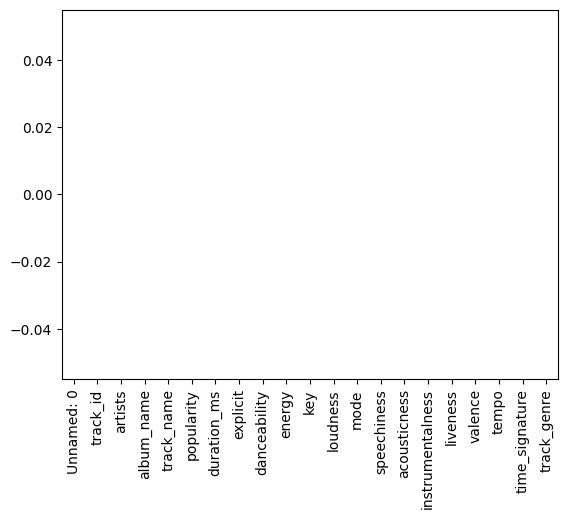

In [ ]:
tracks.dropna(inplace = True)
tracks.isnull().sum().plot.bar()
plt.show()


In [ ]:
tracks = tracks.drop(['track_id'], axis = 1)

In [ ]:
tracks['album_name'].nunique(), tracks.shape

(46589, (113999, 20))

In [ ]:
tracks = tracks.sort_values(by=['popularity'], ascending=False)
tracks.drop_duplicates(subset=['album_name'], keep='first', inplace=True)

In [ ]:
floats = []
for col in tracks.columns:
if tracks[col].dtype == 'float':
	floats.append(col)

len(floats)

9

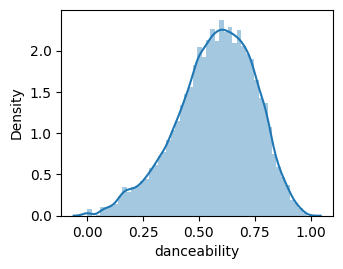

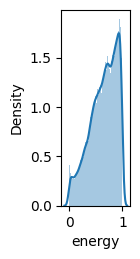

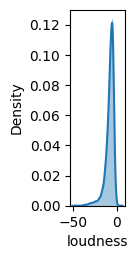

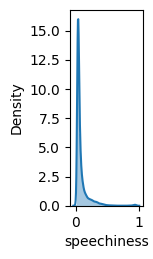

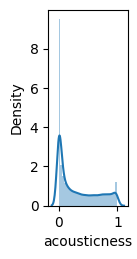

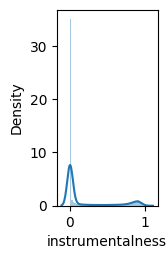

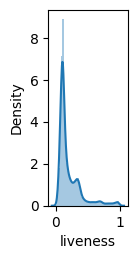

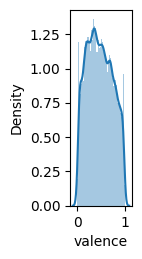

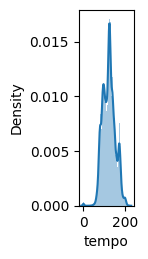

In [ ]:
plt.subplots(figsize = (15, 5))
for i, col in enumerate(floats):
  plt.subplot(2, 5, i + 1)
  sb.distplot(tracks[col])
  plt.tight_layout()
  plt.show()

In [ ]:
%%capture
song_vectorizer = CountVectorizer()
song_vectorizer.fit(tracks['track_genre'])

In [ ]:
tracks = tracks.sort_values(by=['popularity'], ascending=False).head(10000)

In [ ]:
def get_similarities(song_name, data):

	# Getting vector for the input song.
	text_array1 = song_vectorizer.transform(data[data['album_name']==song_name]['track_genre']).toarray()
	num_array1 = data[data['album_name']==song_name].select_dtypes(include=np.number).to_numpy()

	# We will store similarity for each row of the dataset.
	sim = []
	for idx, row in data.iterrows():
		name = row['album_name']

		# Getting vector for current song.
		text_array2 = song_vectorizer.transform(data[data['album_name']==name]['track_genre']).toarray()
		num_array2 = data[data['album_name']==name].select_dtypes(include=np.number).to_numpy()

		# Calculating similarities for text as well as numeric features
		text_sim = cosine_similarity(text_array1, text_array2)[0][0]
		num_sim = cosine_similarity(num_array1, num_array2)[0][0]
		sim.append(text_sim + num_sim)

	return sim

In [ ]:
def recommend_songs(song_name, data=tracks):
# Base case
	if tracks[tracks['album_name'] == song_name].shape[0] == 0:
		print('This song is either not so popular or you\
		have entered invalid_name.\n Some songs you may like:\n')

		for song in data.sample(n=5)['album_name'].values:
			print(song)
		return

	data['similarity_factor'] = get_similarities(song_name, data)

	data.sort_values(by=['similarity_factor', 'popularity'],
					ascending = [False, False],
					inplace=True)

	# First song will be the input song itself as the similarity will be highest.
	display(data[['album_name', 'artists']][2:7])

In [ ]:
recommend_songs('LA PLAYA')

,album_name,artists
104053,Quieres,Aitana;Emilia;Ptazeta
104959,Solo Si Es Contigo (feat. Bebe),Bombai;Bebe
104000,My Life Is Going On (Música Original De La Ser...,Cecilia Krull
104400,Agua Salada,Marc Seguí
104510,Quédate conmigo,Pole.;Pilar Moxó


In [ ]:
recommend_songs('Nem Você Nem Eu')

,album_name,artists
35035,O Som do Bbq,Os Parazim
35040,Esqueminha (Ao Vivo),Max e Luan
35005,Roxinho,Vitor Fernandes;Tarcísio do Acordeon
35032,Simbora pra Vaquejada,Iguinho e Lulinha
47207,Bad Animals,Heart


In [ ]:
recommend_songs('Main Course')

This song is either not so popular or you		have entered invalid_name.
 Some songs you may like:

Main Course
dashstar*
sweater weather / i wanna be your girlfriend
Silver Side Up
Como Antes
